In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy.stats import mode
import tensorflow as tf
import keras

import warnings
warnings.simplefilter(action='ignore',category=[UserWarning, FutureWarning])

### utils

In [6]:
def fill_na_with_rolling_window(data=None, col=None, series=None, n_step=None):
    if col:
        if isinstance(data,pd.DataFrame):
            data['n_roll'] = data[col].rolling(n_step).mean()
            data.loc[data[col].isna(), col] = data.loc[data[col].isna(),'n_roll']
            # display(data.loc[data[col].isna()])
            display(data['n_roll'].isna().sum())
        # elif isinstance(series,pd.Series):
        #     data['n_roll'] = data[col].rolling(n_step)
        #     data.loc[data[col].isna(),col] = data.loc[data[col].isna(),'n_roll']
        else: raise Exception("error")
    return data.drop('n_roll',axis=1)

# without scaling model did not perform so well, try scaling the features
def scale_features(df, name_of_features=[], type_of_features_to_scale=['float'], scaler=MinMaxScaler(), fit=True):
    scaler_map = {}
    if (len(name_of_features)==0) and type(name_of_features)==list:
        for col_no, pair in enumerate(df.dtypes.items()):
            if pair[1] in type_of_features_to_scale:
                # scaler expects df, so do iloc this way, else it will give a series
                if fit:
                    df.iloc[:,col_no:col_no+1] = scaler.fit_transform(df.iloc[:,col_no:col_no+1])
                else:
                    df.iloc[:,col_no:col_no+1] = scaler.transform(df.iloc[:,col_no:col_no+1])
                # scaler_map[pair[0]] = scaler
    else:
        for col_no, pair in enumerate(df.dtypes.items()):
            if pair[0] in name_of_features:
                # scaler expects df, so do iloc this way, else it will give a series
                if fit:
                    df.iloc[:,col_no:col_no+1] = scaler.fit_transform(df.iloc[:,col_no:col_no+1])
                else:
                    df.iloc[:,col_no:col_no+1] = scaler.transform(df.iloc[:,col_no:col_no+1])
                # scaler_map[pair[0]] = scaler
    return (df, scaler_map)



## Weather Forecasting

In [7]:
weather_data = pd.read_csv('data/spark_renewable_ds_forecast_challenge.csv', parse_dates=False)
weather_data.rename(columns={'TimeStamp (UTC)':'ts',
                             'WindDirection Avg':'wind_direction',
                             'WindSpeed Avg':'wind_speed_avg',
                             'WindSpeed StdDev':'wind_speed_std',
                             'T AMB Avg':'temp',
                             'In AirDensity Avg':'density'},inplace=True)

weather_data['ts'] = pd.to_datetime(weather_data['ts'],utc=True)
print(weather_data.shape)
original_weather_cols = weather_data.columns
weather_data.head()

(8760, 6)


,ts,wind_direction,wind_speed_avg,wind_speed_std,temp,density
0,2021-01-01 06:00:00+00:00,NaN,5.110103,NaN,-0.896897,NaN
1,2021-01-01 07:00:00+00:00,NaN,5.221429,NaN,-0.847589,NaN
2,2021-01-01 08:00:00+00:00,NaN,5.411667,NaN,-1.000000,NaN
3,2021-01-01 09:00:00+00:00,NaN,4.855000,NaN,-1.000000,NaN
4,2021-01-01 10:00:00+00:00,NaN,4.369630,NaN,-0.398102,NaN


In [1270]:
# # checking for correlation
# sns.heatmap(weather_data.corr(), annot=False,)

In [1271]:
# checking time intervals in data
# (weather_data.ts - weather_data.ts.shift(1)).dt.total_seconds().unique()

In [1272]:
# fill missing values in wind speed avg with spline interpolation (linear interpolation also does not show much difference from spline)
# plt.figure(figsize=(14,4))
# plt.plot(weather_data.wind_speed_avg.interpolate(option='linear').iloc[range(0,weather_data.shape[0],5)])
weather_data.interpolate(option='linear',inplace=True)
print("nan in wind speed",weather_data['wind_speed_avg'].isna().sum())

nan in wind speed 0


In [1273]:
weather_data.isna().sum(axis=0)

ts                 0
wind_direction    19
wind_speed_avg     0
wind_speed_std    19
temp               0
density           19
dtype: int64

In [1274]:
# still seeing nans, because interpolation did not fill nans at the start
# there is only 19 rows with nans now, which we drop because we have large enough data compared to 19 rows
# we can store persistence predictions here, so we do not miss out on one row when we take shift of column for it
persistence_predictions = weather_data.wind_speed_avg.shift(1)
weather_data.dropna(axis=0,inplace=True)

In [1275]:
# plt.figure(figsize=(14,4))
# plt.plot(weather_data.set_index('ts').wind_speed_avg.rolling(80).mean(),zorder=13)
# plt.plot(weather_data.set_index('ts').wind_speed_avg)
# # plt.plot(weather_data.loc[~weather_data.wind_speed_avg.isna()].set_index('ts').wind_speed_avg,
# #             # weather_data.loc[~weather_data.wind_speed_avg.isna()]['ts'],
# #             c='blue',alpha=0.3,zorder=49)

# # plt.scatter( temp.loc[weather_data['wind_speed_avg'].isna()]['ts'],
# #     temp.loc[weather_data['wind_speed_avg'].isna()].set_index('ts').wind_speed_avg, 
# #     c='magenta',alpha=1,zorder=1, s=100)
# plt.show()
# plt.close()

In [1276]:
# # check if nans occuring are together, also see if any observable patterns for wind speed and other
# fig,ax = plt.subplots(weather_data.shape[1]-1,1,figsize=(10,5),sharex=True)
# scaler = MinMaxScaler()
# for i,col in enumerate(weather_data.columns[1:]):
#     ax[i].plot(scaler.fit_transform(weather_data[col].values.reshape(-1,1)))
#     ax[i].set_title(col,size=10)

In [1277]:
# # check trend, seasonality
# result = seasonal_decompose(weather_data.set_index('ts')['wind_speed_avg'].fillna(weather_data['wind_speed_avg'].mean()), 
#                             model='multiplicative', extrapolate_trend='freq')
# result.plot()
# plt.suptitle('Seasonal Decomposition of Air Passengers Time Series')
# plt.tight_layout()
# plt.show()
# plt.close()


In [1278]:
# from statsmodels.graphics import tsaplots
# tsaplots.plot_pacf(weather_data['wind_speed_avg'].values.squeeze(), lags=10, method="ywm")

In [1279]:
# ts features : 
weather_data['hod'] = weather_data['ts'].dt.hour.astype(float)
weather_data['moy'] = weather_data['ts'].dt.month.astype(float)
ts_features = ['hod','moy']

In [1280]:
# interaction features :
weather_data['temp_density_interaction'] = weather_data['temp'] * weather_data['density']
weather_data['temp_speed_interaction'] = weather_data['temp'] * weather_data['wind_speed_std']
weather_data['temp_direction_interaction'] = weather_data['temp'] * weather_data['wind_direction']
weather_data['speed_direction_interaction'] = weather_data['wind_speed_std'] * weather_data['wind_direction']

interaction_features = ['temp_density_interaction','temp_speed_interaction','temp_direction_interaction','speed_direction_interaction']

In [1281]:
# rolling features :
n3 = 3
weather_data[f'rolling_{n3}_mean_std'] = weather_data.wind_speed_std.rolling(n3).mean()
# weather_data['rolling_5_mean_std'] = weather_data.wind_speed_std.rolling(5).mean()
weather_data[f'rolling_{n3}_mean_temp'] = weather_data.temp.rolling(n3).mean()
weather_data[f'rolling_{n3}_mean_density'] = weather_data.density.rolling(n3).mean()

weather_data[f'rollig_{n3}_var_std'] = weather_data.wind_speed_std.rolling(n3).var()
weather_data[f'rollig_{n3}_var_temp'] = weather_data.temp.rolling(n3).var()
weather_data[f'rollig_{n3}_var_density'] = weather_data.density.rolling(n3).var()

rolling_mean_features = [f'rolling_{n3}_mean_std',f'rolling_{n3}_mean_temp',f'rolling_{n3}_mean_density']
rolling_var_features = [f'rollig_{n3}_var_std',f'rollig_{n3}_var_temp',f'rollig_{n3}_var_density']

In [1282]:
# lag features :
def add_lag_features(df,col_name,timestep):
    timestep_features = []
    for i in range(1,timestep+1):
        df[f'{i}_lag_{col_name}'] = df[col_name].shift(i)
        timestep_features.append(f'{i}_lag_{col_name}')
    return df, timestep_features

# pcaf shows lag 3 is nicely autocorrelated
n1=3
weather_data, lag_speed_features = add_lag_features(weather_data, 'wind_speed_avg', n1)
n2=3
weather_data, lag_temp_features = add_lag_features(weather_data, 'temp', n2)
weather_data, lag_density_features = add_lag_features(weather_data, 'density', n2)
weather_data, lag_direction_features = add_lag_features(weather_data, 'wind_direction', n2)
weather_data, lag_wind_std_features = add_lag_features(weather_data, 'wind_speed_std',n2)
weather_data = weather_data.iloc[max(n1,n2,n3):,:]

In [1283]:
# from sklearn.preprocessing import PolynomialFeatures
# poly = PolynomialFeatures()
# poly_data = poly.fit_transform(weather_data[original_weather_cols].iloc[:,1:])

In [1284]:
target_col = 'wind_speed_avg'
feature_list = []
feature_list.extend(lag_speed_features)
# feature_list.extend(ts_features)
feature_list.extend(interaction_features)
feature_list.extend(rolling_mean_features)
feature_list.extend(rolling_var_features)
feature_list.extend(lag_temp_features)
feature_list.extend(lag_density_features)
feature_list.extend(lag_direction_features)
feature_list.extend(lag_wind_std_features)

In [1285]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.8)
pca.fit(weather_data[feature_list])

target_col_scaler = MinMaxScaler()
target_col_scaler.fit_transform(weather_data[target_col].values.reshape(-1,1))

weather_data, _ = scale_features(weather_data, name_of_features=feature_list, scaler=MinMaxScaler(), fit=True)

In [1286]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

model = RandomForestRegressor(n_estimators=50, max_depth=9,#int(0.7*(len(feature_list))), 
                              random_state=42, min_weight_fraction_leaf=0.001, 
                              min_samples_leaf=5, min_samples_split=40
                            )

# x_train, x_test, y_train, y_test = train_test_split(poly_data, poly_data, test_size=0.1, shuffle=False)
x_train, x_test, y_train, y_test = train_test_split(weather_data[feature_list], weather_data[target_col], test_size=0.1, shuffle=False)
# PCA not improving things
# x_train = pca.transform(x_train)
# x_test = pca.transform(x_test)

# train_set, test_set = [x_train,y_train], [x_train,y_train]
train_set, test_set = [x_train,y_train], [x_test,y_test]

model.fit(train_set[0], train_set[1])
predictions = model.predict(test_set[0])

# predictions = target_col_scaler.inverse_transform(predictions.reshape(-1,1))

print("MAE",mean_absolute_error(test_set[1], predictions))
print("RMSE",root_mean_squared_error(test_set[1], predictions))
print('r2',r2_score(test_set[1], predictions))


MAE 0.7394833504212666
RMSE 0.9746517456913085
r2 0.9077618987437789


In [1287]:
# persistence model's predictions
print("MAE",mean_absolute_error(test_set[1], persistence_predictions.loc[test_set[1].index]))
print("RMSE",root_mean_squared_error(test_set[1], persistence_predictions.loc[test_set[1].index]))
print('r2',r2_score(test_set[1], persistence_predictions.loc[test_set[1].index]))

MAE 0.847292113665904
RMSE 1.1297518121625048
r2 0.8760696952635254


In [1288]:
# pd.Series(model.feature_importances_,index=feature_list).nlargest(5).plot(kind='barh')

In [1289]:
# import pickle
# # save
# with open('wind_forecast_model.pkl','wb') as f:
#     pickle.dump(model,f)

# # load
# import pickle
# with open('wind_forecast_model.pkl', 'rb') as f:
#     model = pickle.load(f)

# model.predict(X[0:1])

In [1290]:
# import xgboost as xg

# # Train and test set are converted to DMatrix objects, 
# # as it is required by learning API. 
# train_dmatrix = xg.DMatrix(data = train_set[0], label = train_set[1]) 
# test_dmatrix = xg.DMatrix(data = test_set[0], label = test_set[1]) 


# param = {"booster":"gblinear", "objective":"reg:linear"} 
  
# xgb_r = xg.train(params = param, dtrain = train_dmatrix, num_boost_round = 10)
# predictions = xgb_r.predict(test_dmatrix) 

# # predictions = target_col_scaler.inverse_transform(predictions.reshape(-1,1))

# print("MAE",mean_absolute_error(test_set[1], predictions))
# print("RMSE",root_mean_squared_error(test_set[1], predictions))

In [1291]:
from sklearn.linear_model import LinearRegression, PassiveAggressiveRegressor

model = LinearRegression()

model.fit(train_set[0], train_set[1])
predictions = model.predict(test_set[0])

# predictions = target_col_scaler.inverse_transform(predictions.reshape(-1,1))

print("MAE",mean_absolute_error(test_set[1], predictions))
print("RMSE",root_mean_squared_error(test_set[1], predictions))
print('r2',r2_score(test_set[1], predictions))

MAE 0.6455760261966363
RMSE 0.869074238896857
r2 0.9266626559256362


In [1298]:
# # check if residuals are normally distributed
# plt.hist(predictions - test_set[1])

In [1302]:
# # # analysing predictions
# plt.figure(figsize=(14,4))
# plt.plot(predictions)
# plt.plot(y_test.reset_index(drop=True))
# # plt.plot(weather_data.loc[y_test.index]['wind_direction'].reset_index(drop=True))

In [1294]:
awd

NameError: name 'awd' is not defined

In [1295]:
import keras
model = keras.Sequential()
scaler = MinMaxScaler()

# train_set, test_set = [x_train,y_train], [x_train,y_train]
train_set, test_set = [x_train,y_train], [x_test,y_test]

scaler.fit(weather_data[feature_list])
train_set[0] = scaler.transform(train_set[0])
test_set[0] = scaler.transform(test_set[0])
scaler.fit(weather_data[target_col].values.reshape(-1,1))
train_set[1] = scaler.transform(train_set[1].values.reshape(-1,1))

data_tensor = tf.convert_to_tensor(train_set[0], dtype=tf.float32)

# input_shape=(train_set[0].shape[1],)
model.add(keras.layers.Dense(data_tensor.shape[1], activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1, activation='linear'))

model.compile(loss='mean_squared_error',optimizer='adam')

model.fit(data_tensor, train_set[1], batch_size=32, epochs=100, validation_split=0.2, verbose=0)
# model.summary()
predictions = model.predict(test_set[0],)

predictions = scaler.inverse_transform(predictions)

# predictions = target_col_scaler.inverse_transform(predictions.reshape(-1,1))

print("MAE",mean_absolute_error(test_set[1], predictions))
print("RMSE",root_mean_squared_error(test_set[1], predictions))
print("r2 score",r2_score(test_set[1], predictions))

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MAE 0.6745209419785035
RMSE 0.8956371513148208
r2 score 0.9221110903563265


In [1296]:
# LSTM approach
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

data = train_set[0].reshape(-1,len(feature_list),1)
# Define the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Fit the model
model.fit(data, train_set[1], epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
# model.summary()
predictions = model.predict(test_set[0],)

predictions = scaler.inverse_transform(predictions)

# predictions = target_col_scaler.inverse_transform(predictions.reshape(-1,1))

print("MAE",mean_absolute_error(test_set[1], predictions))
print("RMSE",root_mean_squared_error(test_set[1], predictions))
print("r2 score",r2_score(test_set[1], predictions))

Epoch 1/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0341 - val_loss: 0.0088
Epoch 2/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0094 - val_loss: 0.0059
Epoch 3/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0074 - val_loss: 0.0060
Epoch 4/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0066 - val_loss: 0.0054
Epoch 5/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0066 - val_loss: 0.0051
Epoch 6/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0060 - val_loss: 0.0069
Epoch 7/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0063 - val_loss: 0.0067
Epoch 8/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0065 - val_loss: 0.0054
Epoch 9/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0063 - val_loss: 0.0051
Epoch 10/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0063 - val_loss: 0.0049
Epoch 11/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0056 - val_loss: 0.0049
Epoch 12/100
197/197 ━━━━━━━━━

In [1085]:
# accuracy for time horizon
time_horizon =48
predictions_next_48 = []
for i in range( 0,test_set[1].shape[0] - time_horizon):
    predictions_next_48.append((predictions[i: i+time_horizon]).flatten())
predictions_next_48 = np.array(predictions_next_48)

actual_next_48 = []
for i in range( 0,test_set[1].shape[0] - time_horizon):
    actual_next_48.append(test_set[1].iloc[i: i+time_horizon])
actual_next_48 = np.array(actual_next_48).reshape(predictions_next_48.shape)

time_horizon =48
persistence_predictions_next_48 = []
for i in range( 0,test_set[1].shape[0] - time_horizon):
    persistence_predictions_next_48.append(persistence_predictions[test_set[1].index].iloc[i: i+time_horizon])
persistence_predictions_next_48 = np.array(persistence_predictions_next_48).reshape(predictions_next_48.shape)

# mean absolute error for next 48 hours
print("persist",np.mean(list(map(sum,abs(persistence_predictions_next_48 - actual_next_48)))))
print("model",np.mean(list(map(sum,abs(predictions_next_48 - actual_next_48)))))

persist 40.500983624523
model 36.640939375021134


## Anomaly Detection

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
time_series = pd.read_csv("data/anomaly_detection.csv")
time_series['date'] = pd.date_range(start='1/1/2016', end='30/12/2016')
print(time_series.shape)
time_series.head()

original_cols = ['CEACC','CCDEF','FAXAE','FBFFD','EDDAB']

(365, 6)


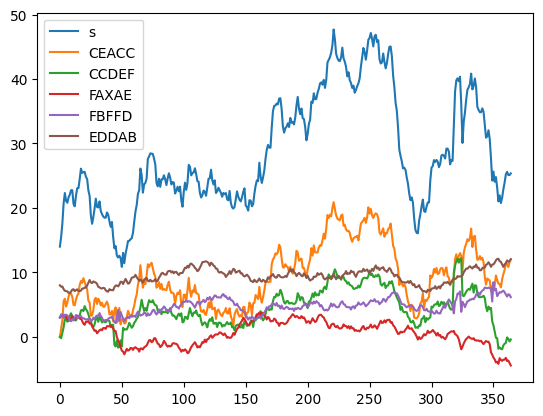

In [24]:
# reasons for taking sum instead of multiply, abs(sum) : 0 values present for sensor, z_score of additive seem to make the anomaly look reasonable
time_series['s'] = time_series[original_cols].sum(axis=1)
# time_series['s'] = time_series['CEACC'] * time_series['CCDEF'] * time_series['FAXAE'] * time_series['FBFFD'] * time_series['EDDAB']
# time_series['s'] = time_series[['CEACC','FAXAE','CCDEF']].sum(axis=1)
# i = time_series[original_cols[0]]
# for col in original_cols[1:]:
#     time_series['s'] = i*time_series[col]
time_series.s.plot()
time_series.CEACC.plot()
time_series.CCDEF.plot()
time_series.FAXAE.plot()
time_series.FBFFD.plot()
time_series.EDDAB.plot()
plt.legend()
plt.show()
plt.close()

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.8)
# pca.fit_transform(time_series[original_cols])
time_series['pc_1'] = list(map(lambda x: x[0], pca.fit_transform(time_series[original_cols])))
# sns.barplot(pca.explained_variance_)

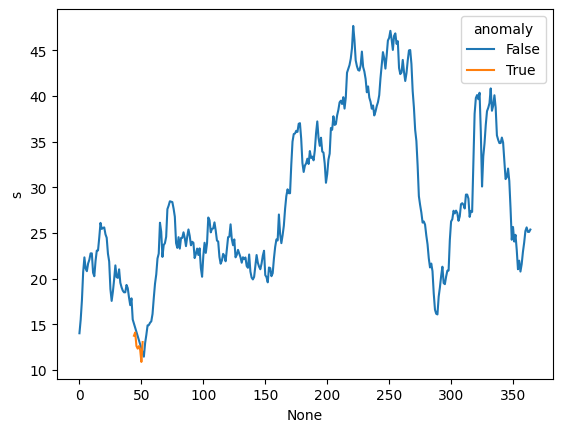

In [26]:
anomaly_start_doy, anomaly_end_doy = pd.to_datetime('2016-02-14').day_of_year, pd.to_datetime('2016-02-21').day_of_year

time_series['doy'] = time_series.date.dt.day_of_year
time_series['anomaly'] = False
time_series.loc[(time_series['doy']>=anomaly_start_doy) & (time_series['doy']<=anomaly_end_doy),'anomaly'] = True

sns.lineplot(data=time_series,y='s',x=time_series.index, hue='anomaly')
plt.show()
plt.close()

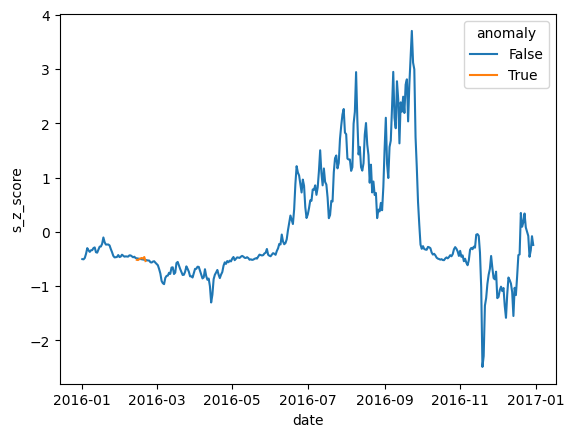

In [23]:
scaler = StandardScaler()
time_series['s_z_score'] = scaler.fit_transform(time_series['s'].values.reshape(-1,1))
sns.lineplot(data=time_series,y='s_z_score',x=time_series.date, hue='anomaly')
# plt.vlines(x=pd.to_datetime('2016-02-14'),ymin=-2,ymax=2,linestyles='dashed',color='orange')
# plt.vlines(x=pd.to_datetime('2016-02-21'),ymin=-2,ymax=2,linestyles='dashed',color='orange')
plt.show()
plt.close()

In [14]:
import pandas as pd
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt


In [15]:
# Exclude datetime column again
# np.random.seed(42)
data_tensor = tf.convert_to_tensor(time_series['s'].values, dtype=tf.float32)

# Define the autoencoder model
# input_dim = time_series[original_cols].shape[1] - 1
input_dim = 1
encoding_dim = 10

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='relu')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile and fit the model
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(data_tensor, data_tensor, epochs=100,
                batch_size=32, shuffle=True)

# Calculate the reconstruction error for each data point
reconstructions = autoencoder.predict(data_tensor)
mse = tf.reduce_mean(tf.square(data_tensor - reconstructions),
                     axis=1)
anomaly_scores = pd.Series(mse.numpy(), name='anomaly_scores')
anomaly_scores.index = time_series.index


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 93.9256 
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 76.4267
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 61.5465
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 47.6302
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 36.4305
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 29.0597
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 22.6245
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 17.1797
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 10.8975
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 8.3996
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 5.5530
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 3.5300
Epoch 13/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 2.0075
Epoch 14/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 1.3187
Epoch 15/100
12/12 ━━━━━━━━━━━━━━

In [27]:
# autoencoder.save('model.keras')
# import keras
# a = keras.models.load_model('model.keras')
# a.summary()

In [28]:
# a = pd.DataFrame({'a':anomalous,'date':time_series['date']})
# a['sess'] = a['a'].diff()
# a.loc[a['a']==False, 'sess'] = np.nan
# a.sess = a.sess.cumsum()
# a = a.groupby('sess').agg(
#     consecutive_days = ('a','count'),
#     start_date = ('date','first'),
#     end_date = ('date','last')
# )
# display(a)
# a = a.loc[a['consecutive_days']>2]
# a.to_json(orient='records')

In [29]:
# import tsod
# rd = tsod.RangeDetector(0.01,2.0)
# anomalous = rd.detect(time_series['s'])
# # time_series['preds'] = res

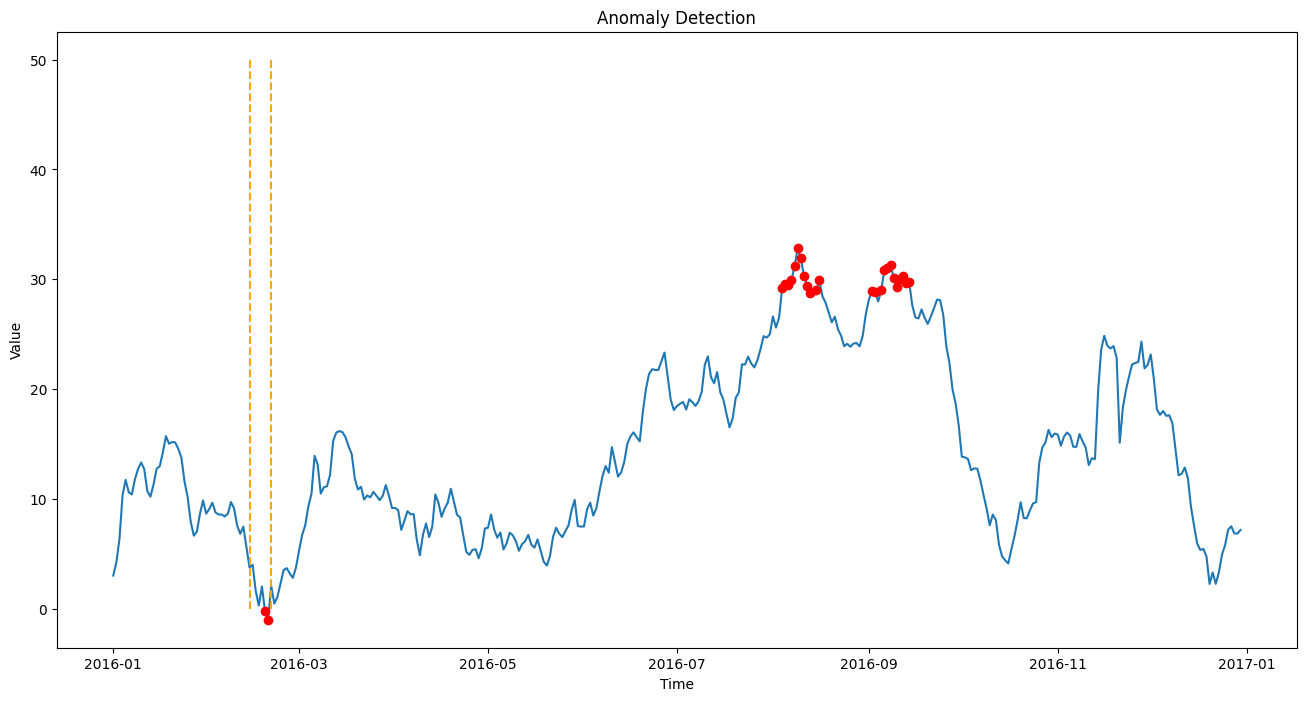

In [19]:
threshold = anomaly_scores.quantile(0.93)
anomalous = anomaly_scores > threshold
binary_labels = anomalous.astype(int)
# precision, recall,\
#     f1_score, _ = precision_recall_fscore_support(
#         binary_labels, anomalous, average='binary')
# Plot the data with anomalies marked in red
plt.figure(figsize=(16, 8))
plt.plot(time_series['date'],
         time_series['s']
        # time_series[original_cols]
         )
plt.plot(time_series['date'][anomalous],
         time_series['s'][anomalous], 
        # time_series[original_cols][anomalous]
         'ro')
plt.vlines(x=pd.to_datetime('2016-02-14'),ymin=0,ymax=50,linestyles='dashed',color='orange')
plt.vlines(x=pd.to_datetime('2016-02-21'),ymin=0,ymax=50,linestyles='dashed',color='orange')
plt.title('Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


In [32]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(class_weight={True:4,False:1}, max_depth=9,#int(0.7*(len(feature_list))), 
                              random_state=42, #min_weight_fraction_leaf=0.001, 
                              #min_samples_leaf=5, min_samples_split=40
                            )

train_indices = time_series.date<='2016-09-30'
test_indices = time_series.date>'2016-09-30'

x_train, x_test = time_series.loc[train_indices][original_cols], time_series.loc[test_indices][original_cols]
y_train, y_test = time_series.loc[train_indices]['anomaly'], time_series.loc[test_indices]['anomaly']
# PCA not improving things
# x_train = pca.transform(x_train)
# x_test = pca.transform(x_test)

# train_set, test_set = [x_train,y_train], [x_train,y_train]
train_set, test_set = [x_train,y_train], [x_test,y_test]

# test_set[1] = target_col_scaler.inverse_transform(test_set[1].values.reshape(-1,1))

classifier.fit(train_set[0], train_set[1])
predictions = classifier.predict(test_set[0])

time_series.loc[test_indices,'preds'] = predictions

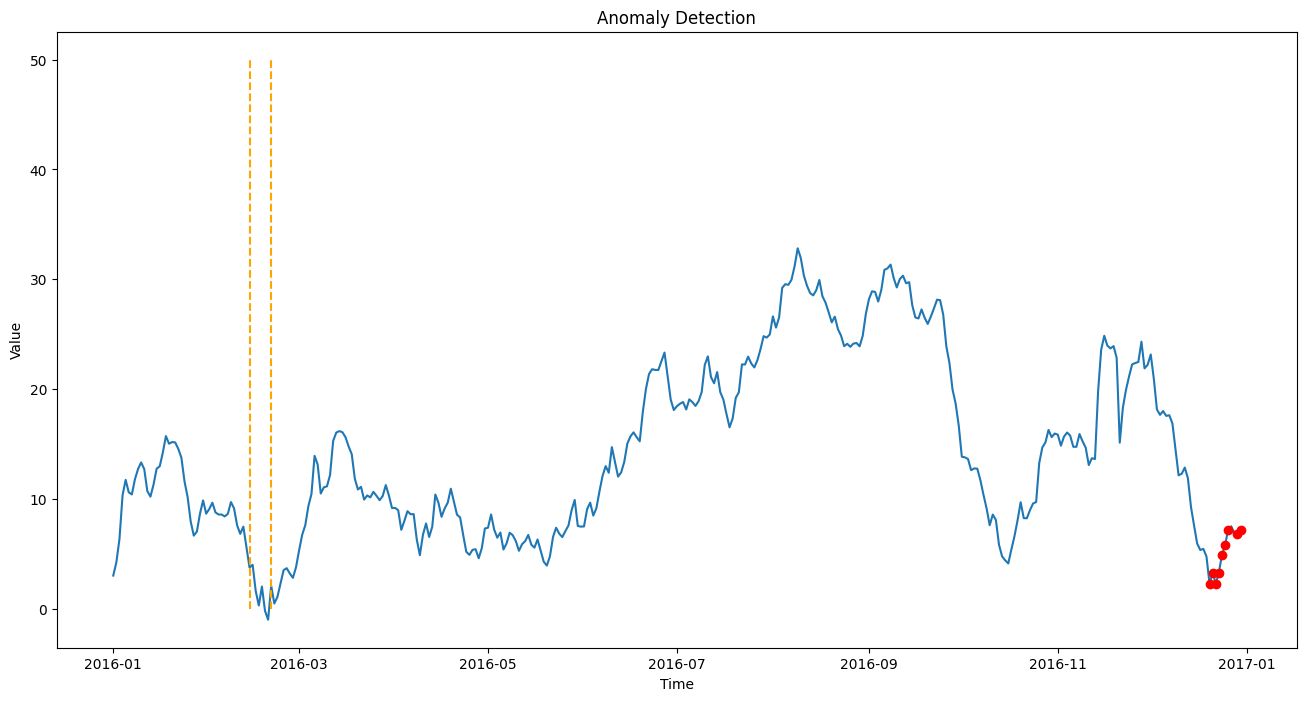

In [33]:
plt.figure(figsize=(16, 8))
plt.plot(time_series['date'],
         time_series['s']
        # time_series[original_cols]
         )
plt.plot(time_series.loc[test_indices & time_series['preds'],'date'],
         time_series.loc[test_indices & time_series['preds'],'s'], 
        # time_series[original_cols][anomalous]
         'ro')
plt.vlines(x=pd.to_datetime('2016-02-14'),ymin=0,ymax=50,linestyles='dashed',color='orange')
plt.vlines(x=pd.to_datetime('2016-02-21'),ymin=0,ymax=50,linestyles='dashed',color='orange')
plt.title('Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


In [34]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(x_train, y_train)
preds = clf.predict(x_test)
preds

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [1337]:
# from sklearn.ensemble import IsolationForest
# from sklearn.pipeline import make_pipeline
# clf = make_pipeline(StandardScaler(), IsolationForest())
# clf.fit(x_train, y_train)
# preds = clf.predict(x_test)
# time_series['preds'] = preds

In [69]:
time_series.cluster.value_counts()

cluster
 0    340
 3     15
 2      5
 1      3
-1      2
Name: count, dtype: int64

Text(0.5, 1.0, 'kissie lelo')

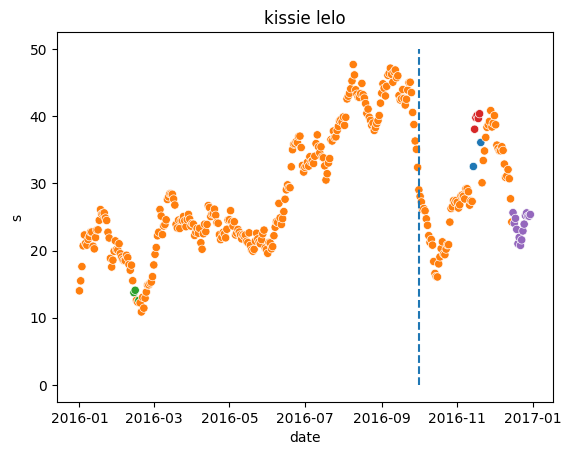

In [74]:
from sklearn.cluster import DBSCAN
shifu = DBSCAN(2.2,min_samples=3)
time_series['cluster'] = shifu.fit_predict(time_series[original_cols],time_series['anomaly'])
plt.vlines(x=pd.to_datetime('2016-10-01'),ymin=0,ymax=50,linestyles='dashed')
sns.scatterplot(data=time_series,x=time_series.date,y='s',hue='cluster', palette="tab10",legend=False)
plt.title('kissie lelo')

In [115]:
# import pickle
# # save
# with open('anomaly_detector.pkl','wb') as f:
#     pickle.dump(shifu,f)

# # load
# import pickle
# with open('wind_forecast_model.pkl', 'rb') as f:
#     model = pickle.load(f)

# model.predict(X[0:1])

In [108]:
a = pd.DataFrame({'a':time_series['cluster'],'date':time_series['date']})
a['a'] = time_series.cluster != mode(time_series.cluster)[0]
a['sess'] = a['a'].diff()
a.loc[a['a']==False, 'sess'] = np.nan
a.sess = a.sess.cumsum()
a = a.groupby('sess').agg(
    consecutive_days = ('a','count'),
    start_date = ('date','first'),
    end_date = ('date','last')
)
display(a)
a = a.loc[a['consecutive_days']>2]
a.to_json(orient='records')

,a,date,sess
0,False,2016-01-01,NaN
1,False,2016-01-02,NaN
2,False,2016-01-03,NaN
3,False,2016-01-04,NaN
4,False,2016-01-05,NaN
...,...,...,...
360,True,2016-12-26,4.0
361,True,2016-12-27,4.0
362,True,2016-12-28,4.0
363,True,2016-12-29,4.0
